In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

- 전처리 된 데이터 프레임 불러오기

In [2]:
PROCESSED_DIR = os.path.join('..', '전처리완료')

df_customers = pd.read_parquet(os.path.join(PROCESSED_DIR, 'customers_clean.parquet'))
df_articles = pd.read_parquet(os.path.join(PROCESSED_DIR, 'articles_clean.parquet'))
df_transactions = pd.read_parquet(os.path.join(PROCESSED_DIR, 'transactions_clean.parquet'))

print("---" * 15)
print(" 전처리 완료 데이터 불러오기 성공")

---------------------------------------------
 전처리 된 데이터 불러오기 성공


- 폰트 깨짐 방지

In [3]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') # Windows는 '맑은 고딕'
else:
    # 리눅스 환경 대비
    plt.rc('font', family='NanumGothic')

# 마이너스 기호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

- 테이블 조인 (필요한 컬럼만 가져와야 메모리 효율이 높음)

In [ ]:

df_merged = pd.merge(df_transactions[['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']], 
                     df_customers[['customer_id', 'age_group_biz']], 
                     on='customer_id', how='inner')

df_merged = pd.merge(df_merged, 
                     df_articles[['article_id', 'prod_name', 'product_group_name', 'graphical_appearance_name', 'index_group_name']], 
                     on='article_id', how='left')

# 2. 장바구니(Basket) 정의: 같은 날짜 + 같은 고객

# basket_size ----> 장바구니에 담긴 상품 개수
basket_df = df_merged.groupby(['t_dat', 'customer_id']).agg({
    'article_id': 'count',
    'age_group_biz': 'first' 
}).reset_index()

basket_df.rename(columns={'article_id': 'basket_size'}, inplace=True)

# 3. 단품(Single) vs 다품(Multi) 라벨링까지
basket_df['type'] = basket_df['basket_size'].apply(lambda x: 'Single (1개)' if x == 1 else 'Multi (2개 이상)')

print("✅ 분석 준비 완료!")

✅ 분석 준비 완료!


- WHO 누가 1개만 사는가?

C:\Users\urina\AppData\Local\Temp\ipykernel_13040\1583817417.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_basket_counts = basket_df.groupby(['age_group_biz', 'type']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

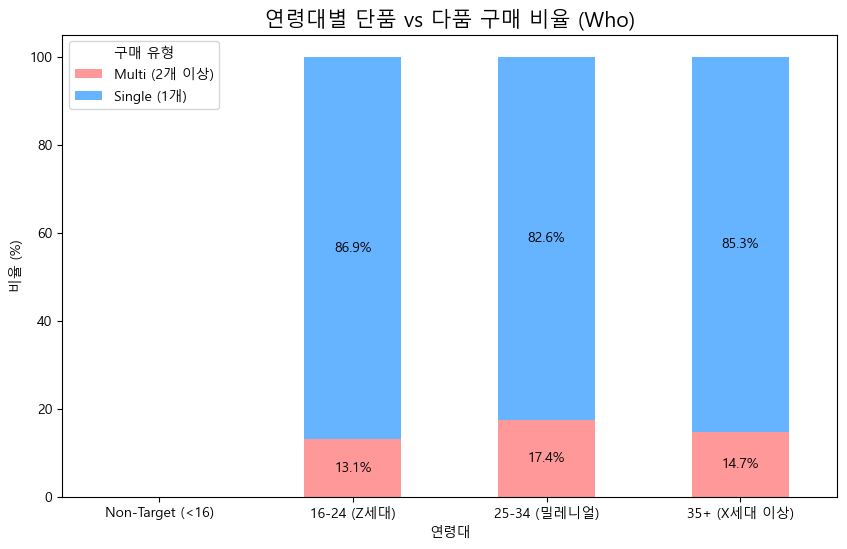

In [15]:
# 1. 연령대별 단품/다품 비율 계산
age_basket_counts = basket_df.groupby(['age_group_biz', 'type']).size().unstack(fill_value=0)

# 2. 비율(%)로 변환 (각 연령대별 합이 100%가 되도록)
age_basket_ratio = age_basket_counts.div(age_basket_counts.sum(axis=1), axis=0) * 100

# 3. 시각화 (Stacked Bar Chart)
plt.figure(figsize=(12, 6))
ax = age_basket_ratio.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(10, 6))

plt.title("연령대별 단품 vs 다품 구매 비율 (Who)", fontsize=15)
plt.ylabel("비율 (%)")
plt.xlabel("연령대")
plt.legend(title='구매 유형', loc='upper left')
plt.xticks(rotation=0)

# 비율 숫자 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0: # 데이터가 있을 때만
        ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center')

plt.show()

- What 어떤 상품이 '혼자' 팔리는가?

C:\Users\urina\AppData\Local\Temp\ipykernel_13040\3876357050.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_lonely_items.values, y=top_lonely_items.index, palette='Reds_r')


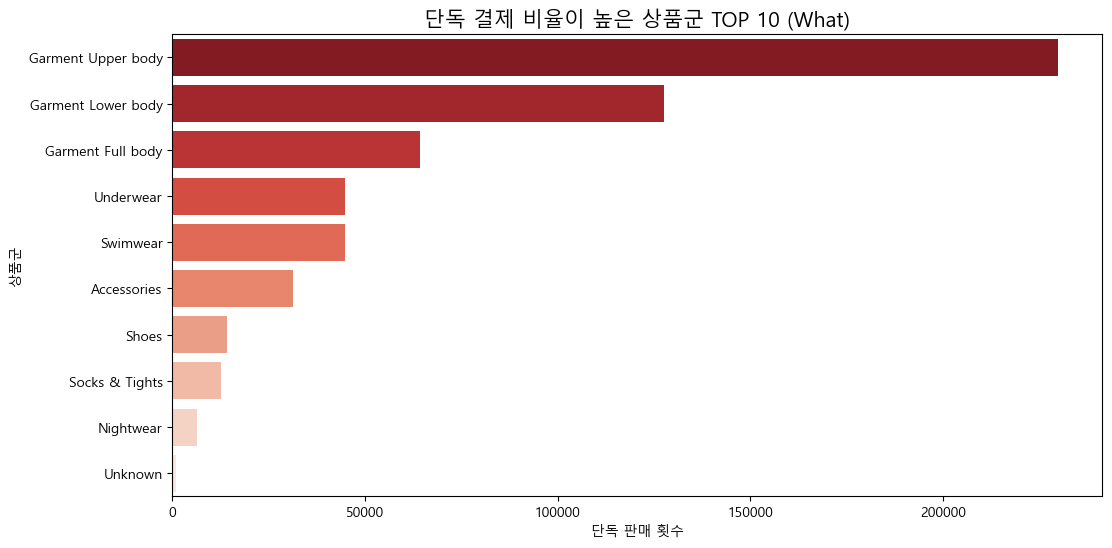

In [12]:
# 1. '단품 구매' 거래만 필터링
single_baskets = basket_df[basket_df['type'] == 'Single (1개)']
single_transactions = df_merged[df_merged.set_index(['t_dat', 'customer_id']).index.isin(single_baskets.set_index(['t_dat', 'customer_id']).index)]

# 2. 상품 그룹별 단독 판매 횟수 집계 --> 상위 10개만
top_lonely_items = single_transactions['product_group_name'].value_counts().head(10)

# 3. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=top_lonely_items.values, y=top_lonely_items.index, palette='Reds_r')

plt.title("단독 결제 비율이 높은 상품군 TOP 10 (What)", fontsize=15)
plt.xlabel("단독 판매 횟수")
plt.ylabel("상품군")
plt.show()

- How: 무엇을 '같이' 사는가? (히트맵)

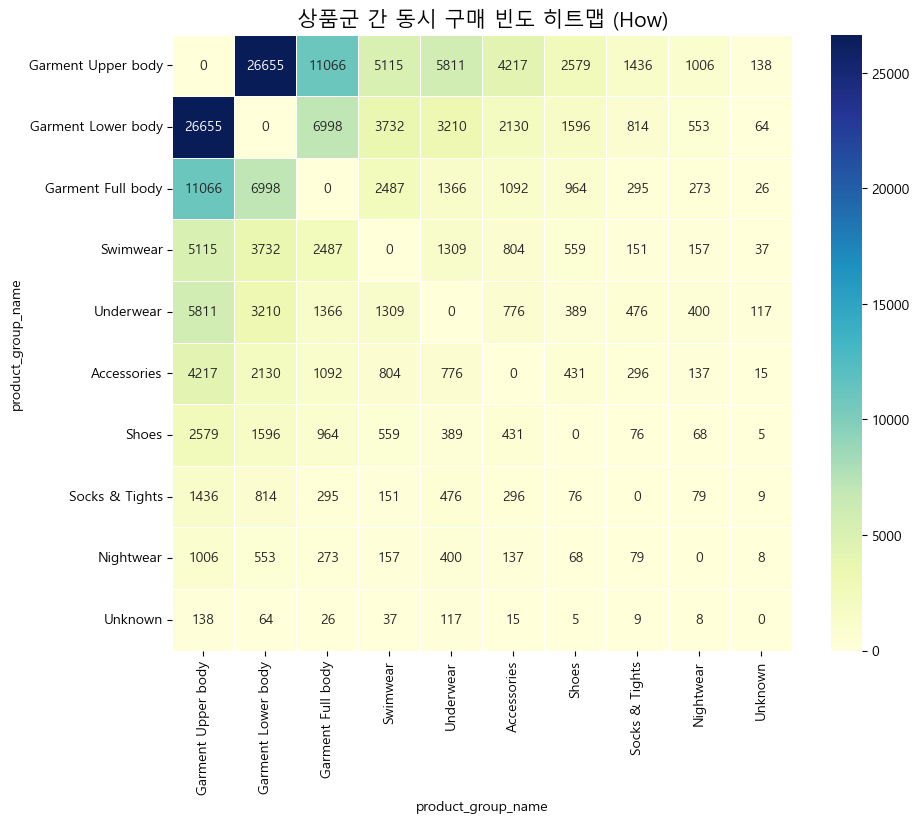

In [ ]:
# 1. '다품 구매' 거래만 필터링
multi_baskets = basket_df[basket_df['type'] == 'Multi (2개 이상)']
multi_transactions = df_merged[df_merged.set_index(['t_dat', 'customer_id']).index.isin(multi_baskets.set_index(['t_dat', 'customer_id']).index)]

# 2. 같은 영수증 내 상품 조합 찾기 product_group_name < --- 
basket_items = multi_transactions[['t_dat', 'customer_id', 'product_group_name']]

# 같은 장바구니의 상품들을 리스트로 묶기 -> 자체 merge 기능이 있음

# 같은 Basket ID를 가진 상품끼리 결합
pairs = pd.merge(basket_items, basket_items, on=['t_dat', 'customer_id'])

pairs = pairs[pairs['product_group_name_x'] != pairs['product_group_name_y']]

# 3. 히트맵 데이터 생성 --> Pivot을 돌려서??
heatmap_data = pd.crosstab(pairs['product_group_name_x'], pairs['product_group_name_y'])

# 상위 10개만 필터링
top_10_groups = multi_transactions['product_group_name'].value_counts().head(10).index
heatmap_data_top = heatmap_data.loc[top_10_groups, top_10_groups]

# 4. 시각화 ---> 히트맵으로
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_top, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title("상품군 간 동시 구매 빈도 히트맵 (How)", fontsize=15)
plt.show()

4. 상의 하의 이름 조합 개수세기

- 판매량이 많은 순서대로 정렬 (상위 10개)

In [ ]:
# 상의 이름 + 하의 이름 조합의 개수를 셉니다.
top_bottom_counts = df_sets.groupby(['prod_name_top', 'prod_name_bottom']).size().reset_index(name='count')

# 판매량이 많은 순서대로 정렬 (Top 10)
best_sets = top_bottom_counts.sort_values(by='count', ascending=False).head(10)

print("--- 20대가 가장 많이 산 [상의 + 하의] 조합 TOP 10 ---")
print(best_sets)